# 1. División del Dataset

## Evaluación Inicial del Dataset

Luego de analizar el dataset y reducirlo a 5,123 ejemplos, surge la necesidad de realizar un etiquetado inicial para distinguir entre juegos "relevantes" y "no relevantes". Este proceso es clave para establecer una clasificación inicial y simplificar el análisis posterior. Para lograrlo, se consideran diferentes enfoques:

1. **Heurísticas** basadas en reglas de negocio.
2. **Análisis financiero** utilizando datos históricos de ingresos.
3. **Métodos estadísticos**, como percentiles.

### Enfoque Elegido: Percentiles
Se seleccionó el uso de percentiles debido a las características del conjunto de datos observadas previamente:

- Existe una alta concentración de juegos con ventas totales bajas (alrededor de 1 millón o menos).
- Los juegos con ventas significativamente altas (varios millones) son escasos.

Con base en estas observaciones, se implementará la siguiente estrategia de categorización:

- **90%** de los juegos se etiquetarán como "Irrelevantes", dada su baja contribución en ventas totales.
- Cerca del **10%** restante se considerará "Relevante".
- Dentro de este 10%, los primeros **100 juegos** con mayores ventas se clasificarán como "Muy Relevantes", a modo de un *top* de juegos más exitosos.

Este enfoque es práctico y fácil de implementar, aunque no es perfecto. No incorpora directamente la viabilidad del proyecto o factores como costos y márgenes de beneficio. Sin embargo, al centrarse en las ventas totales como principal métrica, se justifica su elección por ser:

- Intuitivo para visualizar.
- Fácil de comunicar a otros.
- Razonable dentro del contexto de este análisis.

---

## Preparación del Conjunto de Entrenamiento y Pruebas

Una vez categorizados los datos, se procede a dividir el conjunto en proporciones estándar para garantizar un entrenamiento adecuado del modelo y una evaluación confiable de su desempeño:

1. **80% del dataset** se destina al entrenamiento del modelo. Esto asegura suficiente información para que el modelo aprenda las características relevantes.
2. **20% del dataset** se reserva para pruebas y métricas, evaluando así la capacidad del modelo de generalizar a datos no vistos.

### Justificación de la División

Esta proporción es ampliamente aceptada en proyectos de *machine learning* debido a que:

- Permite un balance entre datos para entrenamiento y evaluación.
- Proporciona un conjunto de pruebas lo suficientemente grande para obtener métricas significativas.



In [15]:
import pandas as pd

In [16]:
# Cargar el dataset modificado
file_path = './datasets/game_sales.csv'  # Ruta al archivo
game_sales = pd.read_csv(file_path)

In [17]:
# Ordenar el dataset por ventas totales
game_sales = game_sales.sort_values(by='total_sales', ascending=False).reset_index(drop=True)

# Calcular umbrales
percentile_90 = game_sales['total_sales'].quantile(0.9)
top_100_sales = game_sales.iloc[99]['total_sales']  # Ventas del juego en la posición 100

# Asignar etiquetas
def categorize_sales(row):
    if row['total_sales'] > top_100_sales:
        return 'Muy Relevante'
    elif row['total_sales'] > percentile_90:
        return 'Relevante'
    else:
        return 'Irrelevante'

game_sales['category'] = game_sales.apply(categorize_sales, axis=1)

# Verificar distribución
print(game_sales['category'].value_counts())

# Guardar el dataset con categorías
game_sales.to_csv('./datasets/game_sales_categorized.csv', index=False)

category
Irrelevante      4613
Relevante         411
Muy Relevante      99
Name: count, dtype: int64


In [18]:
# Obtener estadísticos por categoría
ranges_by_category = game_sales.groupby('category')['total_sales'].agg(['min', 'max', 'mean', 'median', 'std'])

print(ranges_by_category)

                 min     max       mean  median        std
category                                                  
Irrelevante     0.01    2.42   0.380106    0.17   0.495418
Muy Relevante  11.24  252.87  28.961010   17.31  34.859713
Relevante       2.43   11.10   4.830511    4.22   2.066012


In [19]:
game_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5123 entries, 0 to 5122
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        5123 non-null   object 
 1   genre        5123 non-null   object 
 2   developer    5123 non-null   object 
 3   total_sales  5123 non-null   float64
 4   category     5123 non-null   object 
dtypes: float64(1), object(4)
memory usage: 200.2+ KB


In [20]:
# Cargar el dataset modificado
file_path = './datasets/game_sales_categorized.csv'  # Ruta al archivo
game_sales = pd.read_csv(file_path)

In [21]:
game_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5123 entries, 0 to 5122
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        5123 non-null   object 
 1   genre        5123 non-null   object 
 2   developer    5123 non-null   object 
 3   total_sales  5123 non-null   float64
 4   category     5123 non-null   object 
dtypes: float64(1), object(4)
memory usage: 200.2+ KB


In [22]:
from sklearn.preprocessing import OrdinalEncoder

# 1. Tokenización simple para title y escalado
game_sales['title_tokenized'] = game_sales['title'].str.split().str.len() / 30

# 2. Ordinal Encoding para genre y escalado
ordinal_encoder_genre = OrdinalEncoder()
game_sales['genre_encoded'] = ordinal_encoder_genre.fit_transform(game_sales[['genre']]) / 30

# 3. Target Encoding para developer y escalado
developer_sales_mean = game_sales.groupby('developer')['total_sales'].mean()
game_sales['developer_encoded'] = game_sales['developer'].map(developer_sales_mean) / 50

# 4. Ordinal Encoding para category
category_order = ['Irrelevante', 'Relevante', 'Muy Relevante']
ordinal_encoder_category = OrdinalEncoder(categories=[category_order])
game_sales['category_encoded'] = ordinal_encoder_category.fit_transform(game_sales[['category']])

# Seleccionar las columnas procesadas para el modelo
pre_dataset = game_sales[['title_tokenized', 'genre_encoded', 'developer_encoded', 'total_sales', 'category_encoded']]

# Ver el nuevo dataset
print(pre_dataset.head())


   title_tokenized  genre_encoded  developer_encoded  total_sales  \
0         0.033333       0.566667           1.377800       252.87   
1         0.066667       0.566667           0.509514       166.39   
2         0.133333       0.500000           0.750950       128.08   
3         0.100000       0.500000           2.379400       118.97   
4         0.033333       0.000000           1.169100       110.96   

   category_encoded  
0               2.0  
1               2.0  
2               2.0  
3               2.0  
4               2.0  


In [23]:
from sklearn.model_selection import train_test_split

# Seleccionar las columnas necesarias para X e y
X = pre_dataset[['title_tokenized', 'genre_encoded', 'developer_encoded', 'total_sales']]
y = pre_dataset['category_encoded']

# Dividir el dataset en entrenamiento (80%) y prueba (20%) estratificado por la categoría
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verificar las distribuciones en los conjuntos
print("Distribución en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))
print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))

# Opcional: Guardar los conjuntos divididos
# X_train.to_csv('./datasets/X_train.csv', index=False)
# X_test.to_csv('./datasets/X_test.csv', index=False)
# y_train.to_csv('./datasets/y_train.csv', index=False)
# y_test.to_csv('./datasets/y_test.csv', index=False)


Distribución en el conjunto de entrenamiento:
category_encoded
0.0    0.900439
1.0    0.080283
2.0    0.019278
Name: proportion, dtype: float64

Distribución en el conjunto de prueba:
category_encoded
0.0    0.900488
1.0    0.080000
2.0    0.019512
Name: proportion, dtype: float64


<h1>Entrenamiento</h1>

## Configuración del Modelo Random Forest

Para entrenar el modelo, utilizaremos el algoritmo **Random Forest** debido a su capacidad para manejar datos mixtos (categóricos y numéricos), su robustez frente al ruido y su habilidad para evitar el sobreajuste al combinar múltiples árboles de decisión. La configuración del modelo incluye los siguientes parámetros clave:

- **n_estimators = 100**: 
  Se entrenarán 100 árboles independientes para buscar el conjunto de decisiones que mejor clasifique los datos. Este valor proporciona un buen equilibrio entre rendimiento y eficiencia computacional.

- **max_depth = 20**: 
  Los árboles tendrán un máximo de 20 niveles de profundidad. Este límite controla la complejidad de los árboles, ayudando a prevenir el sobreajuste al evitar que los árboles aprendan patrones excesivamente específicos del conjunto de entrenamiento.

- **random_state = 42**:
  Fija una semilla para garantizar la reproducibilidad de los resultados. Es útil para comparar diferentes configuraciones o modelos sin que los resultados varíen debido a la aleatoriedad inherente.

- **class_weight = 'balanced'**:
  Este parámetro ajusta automáticamente el peso de las clases en función de su frecuencia en los datos. Al tratar con clases desbalanceadas (como en este caso, donde la mayoría de los juegos son "Irrelevantes"), esta configuración permite al modelo dar más importancia a las clases minoritarias y mejorar la capacidad de predicción en estas.

- **criterion = 'gini'**:
  El criterio de Gini se utiliza para medir la calidad de una división dentro de los árboles. Este criterio calcula la *impureza de Gini*, que indica cuán mezcladas están las clases dentro de un nodo. El objetivo del modelo es minimizar la impureza al dividir los datos, favoreciendo divisiones que produzcan nodos "puros" (es decir, que contengan principalmente ejemplos de una sola clase). Esto ayuda a generar reglas de decisión más precisas.

---

## Observaciones

Es importante tener en cuenta que el parámetro `class_weight` también puede introducir algo de ruido en los árboles al modificar el peso de las clases durante el entrenamiento. Además, al asignar una gran importancia a la característica de ventas totales, el modelo podría generar límites de decisión numéricos estrictos. Sin embargo, con un número adecuado de árboles (`n_estimators`) y un control de la profundidad (`max_depth`), esperamos que el modelo maneje este desafío de manera efectiva.



In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Entrenamiento del modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Número de árboles en el bosque
    max_depth=20,  # Profundidad máxima de los árboles
    random_state=42,  # Para reproducibilidad
    class_weight='balanced',  # Manejar desbalanceo de clases
    criterion='gini'  # Criterio de división
)

# Entrenar el modelo con el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)


<h2>Evaluacion</h2>

In [25]:
# Evaluación inicial
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")

Precisión del modelo: 1.00


In [26]:
# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Irrelevante', 'Relevante', 'Muy Relevante']))


Informe de clasificación:
               precision    recall  f1-score   support

  Irrelevante       1.00      1.00      1.00       923
    Relevante       1.00      1.00      1.00        82
Muy Relevante       1.00      1.00      1.00        20

     accuracy                           1.00      1025
    macro avg       1.00      1.00      1.00      1025
 weighted avg       1.00      1.00      1.00      1025



In [27]:
# Mostrar la importancia de las características
feature_importances = rf_model.feature_importances_
features = X_train.columns
print("\nImportancia de las características:")
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance:.4f}")


Importancia de las características:
title_tokenized: 0.0146
genre_encoded: 0.0032
developer_encoded: 0.2472
total_sales: 0.7349


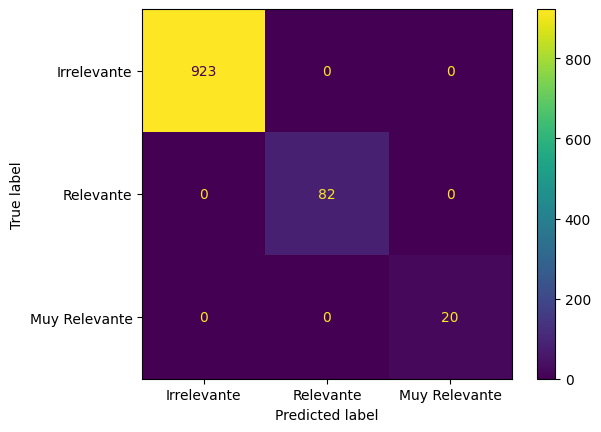

In [28]:
# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, display_labels=['Irrelevante', 'Relevante', 'Muy Relevante'])

## Resultados Iniciales

Tras evaluar el modelo **Random Forest**, obtenemos las siguientes métricas clave:

### Precisión General del Modelo
La precisión general es del **100%**, lo que indica que el modelo clasifica correctamente todos los ejemplos en el conjunto de prueba.

### Informe de Clasificación
El informe de clasificación desglosa el rendimiento por categoría:

| Categoría        | Precisión | Recall | F1-Score | Soporte |
|------------------|-----------|--------|----------|---------|
| **Irrelevante**  | 1.00      | 1.00   | 1.00     | 923     |
| **Relevante**    | 1.00      | 1.00   | 1.00     | 82      |
| **Muy Relevante**| 1.00      | 1.00   | 1.00     | 20      |
| **Promedio Macro**| 1.00      | 1.00   | 1.00     | 1025    |
| **Promedio Ponderado**| 1.00      | 1.00   | 1.00     | 1025    |

El modelo muestra un rendimiento excepcional en todas las métricas y clases, lo que a primera vista podría indicar que generaliza bien. Sin embargo, esta alta precisión podría deberse a características inherentes de los datos más que a un rendimiento sobresaliente del modelo.

---

## Importancia de las Características

La importancia de las características, determinada por el modelo, muestra lo siguiente:

| Característica       | Importancia (%) |
|----------------------|-----------------|
| **title_tokenized**  | 1.46%          |
| **genre_encoded**    | 0.32%          |
| **developer_encoded**| 24.72%         |
| **total_sales**      | 73.49%         |

Es evidente que la característica **`total_sales`** domina el proceso de decisión, representando el **73.49% de la importancia total**. Esto sugiere que los árboles de decisión en el modelo están aprendiendo límites numéricos basados principalmente en las ventas totales, con menor peso para las variables categóricas.

---

## Discusión y Observaciones

1. **Relación entre los Datos y la Generalización**:
   - La alta precisión podría deberse a la estructura del conjunto de datos:
     - Un **90% de los ejemplos pertenecen a la categoría "Irrelevante"**.
     - Al clasificar la mayoría de los ejemplos como irrelevantes y confiar en los valores numéricos de `total_sales`, el modelo puede establecer límites de decisión efectivos para las otras dos categorías.

2. **Impacto de las Etiquetas y Heurísticas**:
   - La técnica de los percentiles utilizada para categorizar los datos permite al modelo generalizar bien, ya que:
     - Se cuenta con muchos ejemplos en la clase mayoritaria ("Irrelevante").
     - Las categorías "Relevante" y "Muy Relevante" son minoritarias pero están claramente delimitadas por las ventas.

3. **Limitaciones del Modelo Actual**:
   - **Datos Insuficientes**: Con solo 5,000 ejemplos, el modelo tiene poco margen para aprender límites de decisión más complejos.
   - **Clase Minoritaria**: Las clases "Relevante" y "Muy Relevante" tienen pocos ejemplos, lo que puede limitar la capacidad del modelo para aprender patrones detallados.

4. **Propuestas de Mejora**:
   - **Aumentar el Conjunto de Datos**: Incorporar más ejemplos con ventas clasificadas en las categorías "Relevante" y "Muy Relevante".
   - **Incluir Nuevas Características**: 
     - **Críticas de jugadores**: Promedio de calificaciones de jugadores y críticas de prensa.
     - **Impacto mediático**: Nivel de exposición mediática de cada videojuego.
     - **Jugadores activos**: Datos de usuarios activos durante el período de análisis.
     - **Contenido adicional (DLCs)**: Cantidad y éxito de contenido descargable.
   - Estas características podrían ayudar a capturar la relevancia de un videojuego desde diferentes perspectivas más allá de las ventas totales.

---

## Conclusión

El modelo demuestra una excelente capacidad para clasificar los datos actuales, principalmente gracias al fuerte peso de la característica numérica `total_sales`. Sin embargo, para garantizar que el modelo funcione bien con nuevos datos o en escenarios más complejos, será necesario incorporar características adicionales y ejemplos más diversos. Este enfoque permitirá desarrollar un límite de decisión más robusto y adaptable a diferentes contextos.
